In [216]:
import pandas as pd
from datetime import datetime,timedelta
import numpy as np
import matplotlib.pylab as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy import stats
from pandas import Series
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from matplotlib import pyplot
from scipy.special import boxcox, inv_boxcox
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.stattools import acf, pacf
import statsmodels.tsa.seasonal as sts
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error, mean_squared_error
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [217]:
dateparse = lambda x: pd.to_datetime(x, format='%m/%d/%Y')

In [218]:
df = pd.read_csv('C:/Users/mohieldine/Desktop/Python Tutorial/Climate Change/GlobalLandTemperaturesByState.csv', infer_datetime_format=True, index_col='dt', parse_dates=['dt'], date_parser=dateparse)
df.head(10)

,AverageTemperature,AverageTemperatureUncertainty,State,Country
dt,,,,
1900-01-01,25.732,1.080,Acre,Brazil
1900-02-01,26.050,1.080,Acre,Brazil
1900-03-01,26.574,0.894,Acre,Brazil
1900-04-01,25.947,1.192,Acre,Brazil
1900-05-01,25.557,0.856,Acre,Brazil
1900-06-01,24.907,1.140,Acre,Brazil
1900-07-01,24.663,0.726,Acre,Brazil
1900-08-01,25.641,0.824,Acre,Brazil
1900-09-01,26.379,0.806,Acre,Brazil


In [194]:
df.dtypes

AverageTemperature               float64
AverageTemperatureUncertainty    float64
State                             object
Country                           object
dtype: object

In [12]:
df.shape

(328965, 4)

In [13]:
df.isnull().sum()

AverageTemperature               181
AverageTemperatureUncertainty    181
State                              0
Country                            0
dtype: int64

In [14]:
df.isnull().mean()*100

AverageTemperature               0.055021
AverageTemperatureUncertainty    0.055021
State                            0.000000
Country                          0.000000
dtype: float64

In [15]:
df.describe()

,AverageTemperature,AverageTemperatureUncertainty
count,328784.000000,328784.000000
mean,9.767931,0.417751
std,13.931064,0.319615
min,-45.389000,0.036000
25%,0.399000,0.238000
50%,12.196000,0.330000
75%,20.916250,0.486000
max,36.339000,7.638000


In [16]:
df['AverageTemperature'] = df['AverageTemperature'].fillna(9.767)
df['AverageTemperatureUncertainty'] = df['AverageTemperatureUncertainty'].fillna(0.417)

In [17]:
df.isnull().sum()

AverageTemperature               0
AverageTemperatureUncertainty    0
State                            0
Country                          0
dtype: int64

In [18]:
df.rename(columns={'AverageTemperatureUncertainty': 'confidence_interval_temp'},inplace=True)

In [19]:
df.head()

,AverageTemperature,confidence_interval_temp,State,Country
dt,,,,
1900-01-01,25.732,1.080,Acre,Brazil
1900-02-01,26.050,1.080,Acre,Brazil
1900-03-01,26.574,0.894,Acre,Brazil
1900-04-01,25.947,1.192,Acre,Brazil
1900-05-01,25.557,0.856,Acre,Brazil


In [22]:
#to use year as index
df['year']= df.index.year
df.head()

,AverageTemperature,confidence_interval_temp,State,Country,year
dt,,,,,
1900-01-01,25.732,1.080,Acre,Brazil,1900
1900-02-01,26.050,1.080,Acre,Brazil,1900
1900-03-01,26.574,0.894,Acre,Brazil,1900
1900-04-01,25.947,1.192,Acre,Brazil,1900
1900-05-01,25.557,0.856,Acre,Brazil,1900


In [24]:
#display the last 5 rows of the data frame

df.tail()

,AverageTemperature,confidence_interval_temp,State,Country,year
dt,,,,,
2013-05-01,21.634,0.578,Zhejiang,China,2013
2013-06-01,24.679,0.596,Zhejiang,China,2013
2013-07-01,29.272,1.340,Zhejiang,China,2013
2013-08-01,29.202,0.869,Zhejiang,China,2013
2013-09-01,9.767,0.417,Zhejiang,China,2013


In [27]:
#Now we use latest data-only to display the data with index from 1980 to 2013
latest_df = df.loc['1980':'2013']
latest_df.head()

,AverageTemperature,confidence_interval_temp,State,Country,year
dt,,,,,
1980-01-01,26.652,0.190,Acre,Brazil,1980
1980-02-01,26.495,0.495,Acre,Brazil,1980
1980-03-01,26.270,0.236,Acre,Brazil,1980
1980-04-01,26.430,0.201,Acre,Brazil,1980
1980-05-01,25.802,0.882,Acre,Brazil,1980


In [28]:
#to provide the average of the country located in specific above mentioned index and group them by country

latest_df[['Country','AverageTemperature']].groupby(['Country']).mean().sort_values('AverageTemperature')

,AverageTemperature
Country,
Canada,-0.679106
Russia,2.450943
United States,11.516203
China,12.144326
Australia,18.426187
India,22.839312
Brazil,24.501110


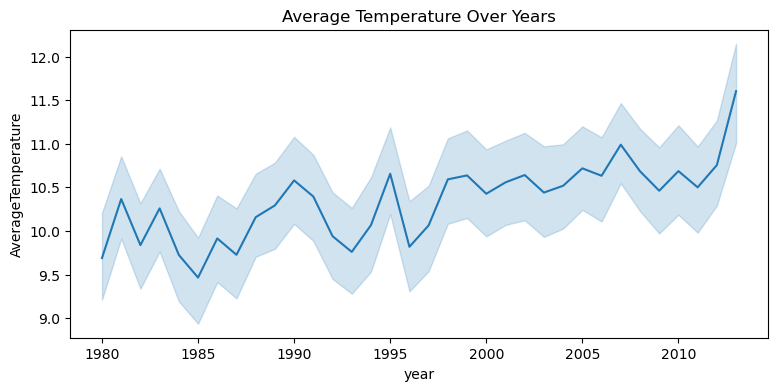

In [30]:
#Plotting graph between year and average temperature
plt.figure(figsize=(9,4))
sns.lineplot(x = "year" , y = "AverageTemperature",data=latest_df)
plt.title('Average Temperature Over Years')
plt.show()

In [31]:
#this code to calculate the average mean of the temperature for each year

resample_df = latest_df['AverageTemperature'].resample('A').mean()
resample_df.head()

dt
1980-12-31     9.689856
1981-12-31    10.366578
1982-12-31     9.837958
1983-12-31    10.259516
1984-12-31     9.724950
Freq: A-DEC, Name: AverageTemperature, dtype: float64

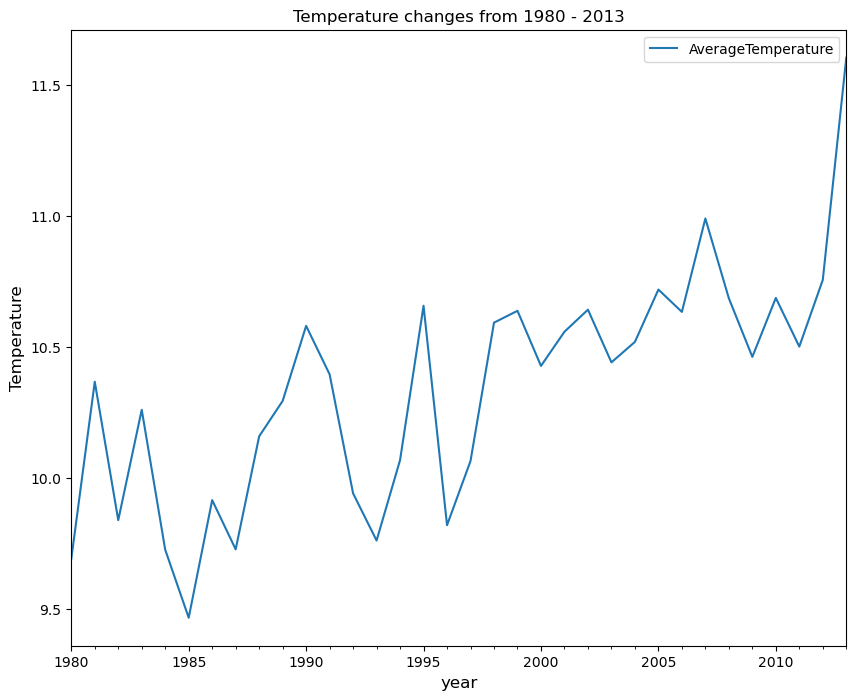

In [35]:
resample_df.plot(title='Temperature changes from 1980 - 2013',figsize=(10,8))
plt.ylabel('Temperature',fontsize=12)
plt.xlabel('year',fontsize=12)
plt.legend()

In [37]:
df1 = pd.DataFrame(resample_df)

In [39]:
df1.shape

(34, 1)

In [40]:
df1.columns

Index(['AverageTemperature'], dtype='object')

In [41]:
#performing the log transformation using numpy- this like you going to make the data more symmetric
log_df = np.log(resample_df)

In [44]:
log_df.head(10)

dt
1980-12-31    2.271080
1981-12-31    2.338587
1982-12-31    2.286248
1983-12-31    2.328206
1984-12-31    2.274695
1985-12-31    2.247647
1986-12-31    2.294000
1987-12-31    2.274857
1988-12-31    2.318267
1989-12-31    2.331486
Freq: A-DEC, Name: AverageTemperature, dtype: float64

In [45]:
log_df.skew()

0.07440794370637349

In [48]:
# split the data into training and testing just for log data
train_size = int(len(log_df) * 0.80)
train, test = log_df[0:train_size], log_df[train_size:]

In [50]:
#split the data into training and testing just for resample data
train_size1 = int(len(resample_df) * 0.80)
train1, test1 = resample_df[0:train_size1], resample_df[train_size1:]

<Axes: ylabel='Density'>

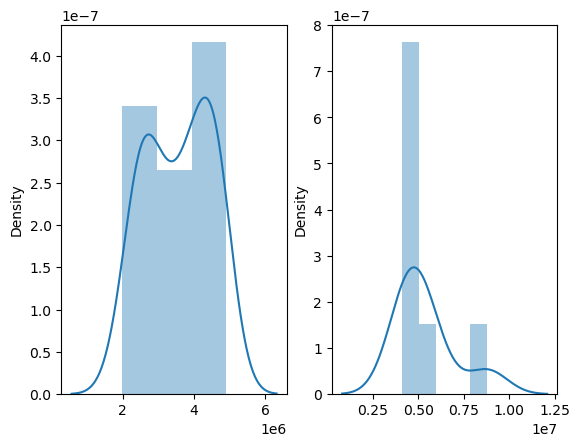

In [53]:
# transform training data & save lambda value
train_data,fitted_lambda = stats.boxcox(train1)

# use lambda value to transform test data
test_data = stats.boxcox(test1, fitted_lambda)

# (optional) plot train & test
fig, ax=plt.subplots(1,2)
sns.distplot(train_data, ax=ax[0])
sns.distplot(test_data, ax=ax[1])

In [54]:
train1.shape

(27,)

In [55]:
test1.shape

(7,)

In [65]:
train1.tail()

dt
2002-12-31    10.641713
2003-12-31    10.440567
2004-12-31    10.518699
2005-12-31    10.718543
2006-12-31    10.633299
Freq: A-DEC, Name: AverageTemperature, dtype: float64

In [66]:
test1.tail()

dt
2009-12-31    10.461537
2010-12-31    10.686661
2011-12-31    10.500732
2012-12-31    10.755588
2013-12-31    11.603875
Freq: A-DEC, Name: AverageTemperature, dtype: float64

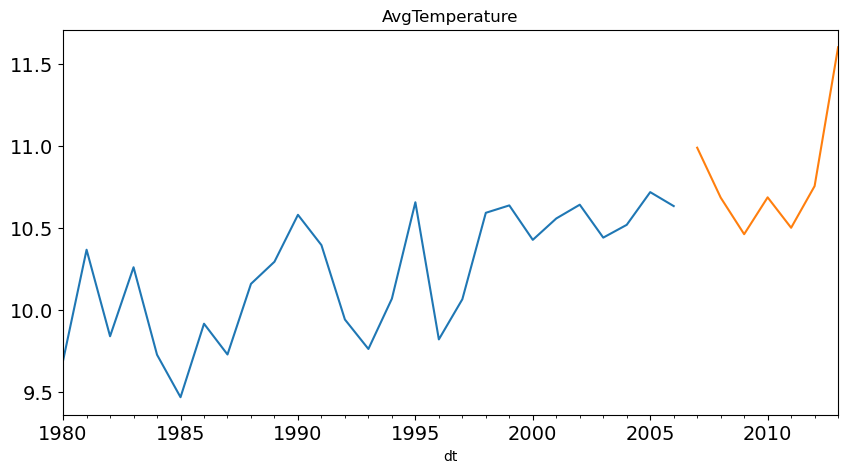

In [67]:
train1.plot(figsize=(10,5), title= 'AvgTemperature', fontsize=14)
test1.plot(figsize=(10,5), title= 'AvgTemperature', fontsize=14)
plt.show()

In [64]:
avgdf = latest_df['AverageTemperature'].mean()

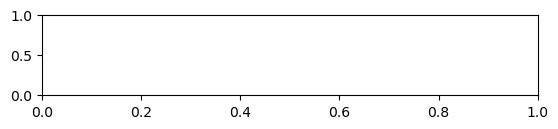

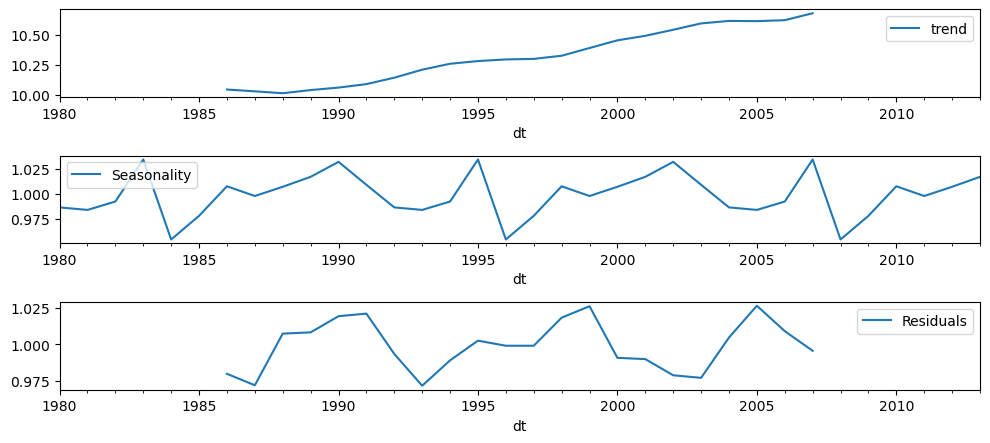

In [71]:
decomposition = sts.seasonal_decompose(resample_df,model='multiplicative', period=12)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
df.plot(kind="line",figsize=(10,6),label='Original')
plt.subplot(412)
trend.plot(kind="line",figsize=(10,6),label='trend')
plt.legend(loc='best')
plt.subplot(413)
seasonal.plot(kind="line",figsize=(10,6),label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
residual.plot(kind="line",figsize=(10,6),label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [76]:
#Build simpleExpsmoothing forecasting model 

train1 = train1.astype('double')
ses = SimpleExpSmoothing(train1).fit()
ses1 = ses.forecast(7)
ses.summary()

Dep. Variable:,AverageTemperature,No. Observations:,27
Model:,SimpleExpSmoothing,SSE,2.764
Optimized:,True,AIC,-57.537
Trend:,None,BIC,-54.945
Seasonal:,None,AICC,-55.719
Seasonal Periods:,None,Date:,"Thu, 21 Dec 2023"
Box-Cox:,False,Time:,15:42:30
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.2905007,alpha,True
initial_level,9.9462899,l.0,True


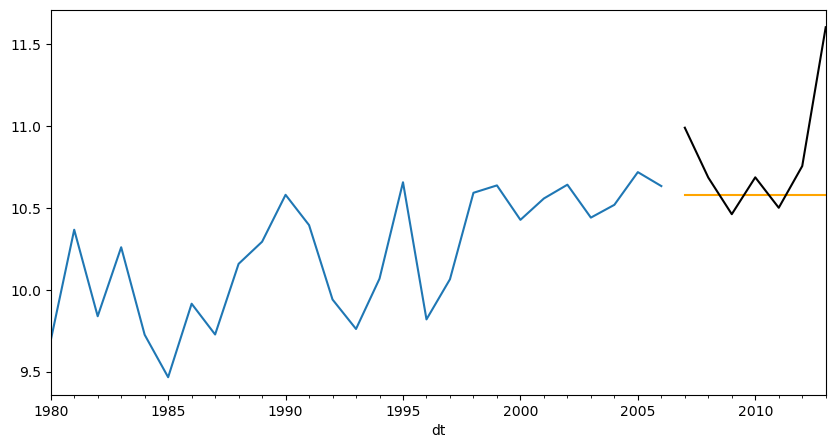

In [75]:
# below visual to display the variance between the train values, smoothing model and test values

train1.plot(kind="line",figsize=(10,5))
ses1.plot(kind="line",figsize=(10,5),color='orange')
test1.plot(kind="line",figsize=(10,5),color='black')
plt.show()

In [80]:
#build ExponentialSmoothing Forecasting Model

hes = ExponentialSmoothing(train1, trend="add").fit()
hes1 = hes.forecast(7)
hes.summary()

Dep. Variable:,AverageTemperature,No. Observations:,27
Model:,ExponentialSmoothing,SSE,2.048
Optimized:,True,AIC,-61.630
Trend:,Additive,BIC,-56.447
Seasonal:,None,AICC,-57.430
Seasonal Periods:,None,Date:,"Thu, 21 Dec 2023"
Box-Cox:,False,Time:,16:08:45
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,1.4901e-08,alpha,True
smoothing_trend,1.3244e-08,beta,True


<Axes: xlabel='dt'>

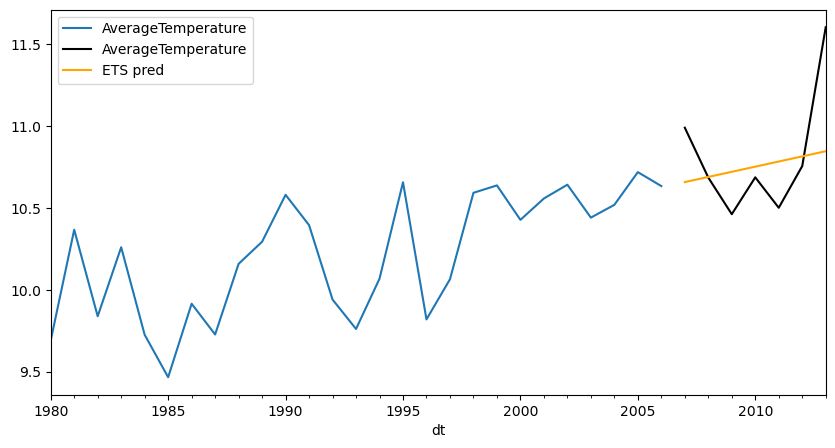

In [81]:
#the below visual to represent the trend of the train model, test model, and forecast model

train1.plot(kind="line",figsize=(10,5),legend=True)
test1.plot(kind="line",figsize=(10,5),legend=True, color='black')
hes1.plot(kind="line",figsize=(10,5),color='orange',legend=True,label='ETS pred')

In [84]:
# This code to create exponentialsmoothing forecasting model using multiplicative method

hwes = ExponentialSmoothing(train1 , seasonal_periods=12 ,trend='add', seasonal="multiplicative").fit()
hwes1 = hwes.forecast(7)
hwes.summary()

Dep. Variable:,AverageTemperature,No. Observations:,27
Model:,ExponentialSmoothing,SSE,0.896
Optimized:,True,AIC,-59.950
Trend:,Additive,BIC,-39.216
Seasonal:,Multiplicative,AICC,25.550
Seasonal Periods:,12,Date:,"Thu, 21 Dec 2023"
Box-Cox:,False,Time:,16:26:13
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,1.4901e-08,alpha,True
smoothing_trend,3.2574e-11,beta,True


<Axes: xlabel='dt'>

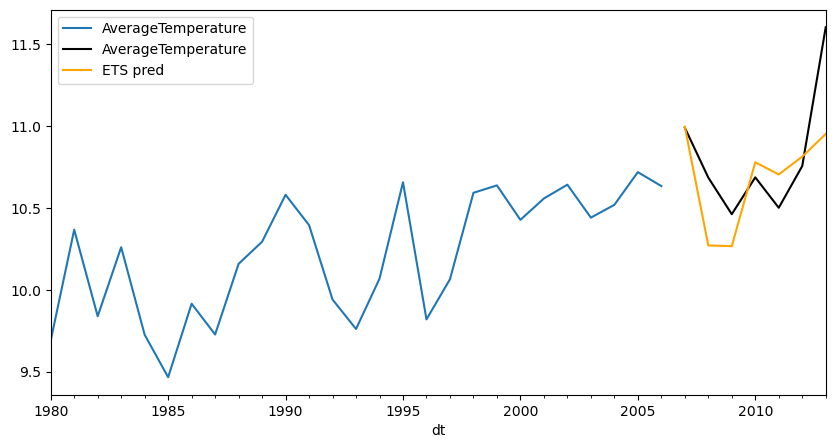

In [85]:
# to show the trend of the train model, test model and forecasting model

train1.plot(kind="line",figsize=(10,5),legend=True)
test1.plot(kind="line",figsize=(10,5),legend=True, color='black')
hwes1.plot(kind="line",figsize=(10,5),color='orange',legend=True,label='ETS pred')

In [87]:
train1

dt
1980-12-31     9.689856
1981-12-31    10.366578
1982-12-31     9.837958
1983-12-31    10.259516
1984-12-31     9.724950
1985-12-31     9.465436
1986-12-31     9.914519
1987-12-31     9.726528
1988-12-31    10.158058
1989-12-31    10.293226
1990-12-31    10.579912
1991-12-31    10.394824
1992-12-31     9.940195
1993-12-31     9.760204
1994-12-31    10.067471
1995-12-31    10.656668
1996-12-31     9.818723
1997-12-31    10.064026
1998-12-31    10.592179
1999-12-31    10.637408
2000-12-31    10.426971
2001-12-31    10.557589
2002-12-31    10.641713
2003-12-31    10.440567
2004-12-31    10.518699
2005-12-31    10.718543
2006-12-31    10.633299
Freq: A-DEC, Name: AverageTemperature, dtype: float64

In [91]:
def test_stationarity(timeseries):
  
    #Determing rolling statistics
    rolmean=pd.core.window.Rolling(timeseries, window=12).mean()
    rolstd = pd.core.window.Rolling(timeseries, window=12).std()



    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(resample_df, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
    
# H0: series is nonstationary
# H1: series is stationary

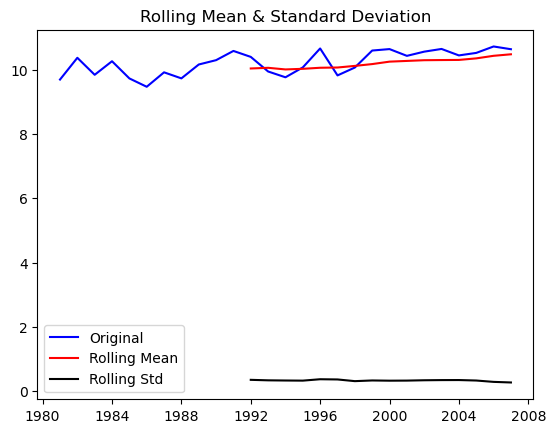

Results of Dickey-Fuller Test:
Test Statistic                 -0.854842
p-value                         0.802480
#Lags Used                      2.000000
Number of Observations Used    31.000000
Critical Value (1%)            -3.661429
Critical Value (5%)            -2.960525
Critical Value (10%)           -2.619319
dtype: float64


In [92]:
test_stationarity(train1)

In [95]:
#to test the auto-correlation at Lag1 for the train data

acorr_ljungbox(train1, lags=[1], return_df=True)

,lb_stat,lb_pvalue
1,5.615776,0.017799


In [96]:
acorr_ljungbox(train_data, lags=[1], return_df=True)

,lb_stat,lb_pvalue
1,5.902979,0.015115


In [97]:
diff1=train1.diff()
diff1=diff1.dropna()

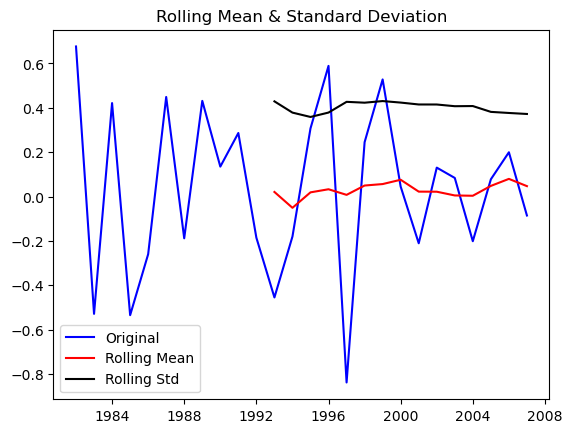

Results of Dickey-Fuller Test:
Test Statistic                 -0.854842
p-value                         0.802480
#Lags Used                      2.000000
Number of Observations Used    31.000000
Critical Value (1%)            -3.661429
Critical Value (5%)            -2.960525
Critical Value (10%)           -2.619319
dtype: float64


In [98]:
test_stationarity(diff1)

In [99]:
diff2=diff1.diff(3)
diff2=diff2.dropna()

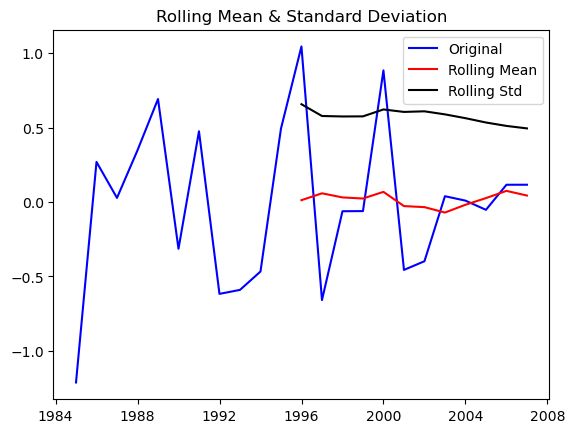

Results of Dickey-Fuller Test:
Test Statistic                 -0.854842
p-value                         0.802480
#Lags Used                      2.000000
Number of Observations Used    31.000000
Critical Value (1%)            -3.661429
Critical Value (5%)            -2.960525
Critical Value (10%)           -2.619319
dtype: float64


In [100]:
test_stationarity(diff2)

In [101]:
acorr_ljungbox(diff2, lags=[1], return_df=True)

,lb_stat,lb_pvalue
1,0.335248,0.562585


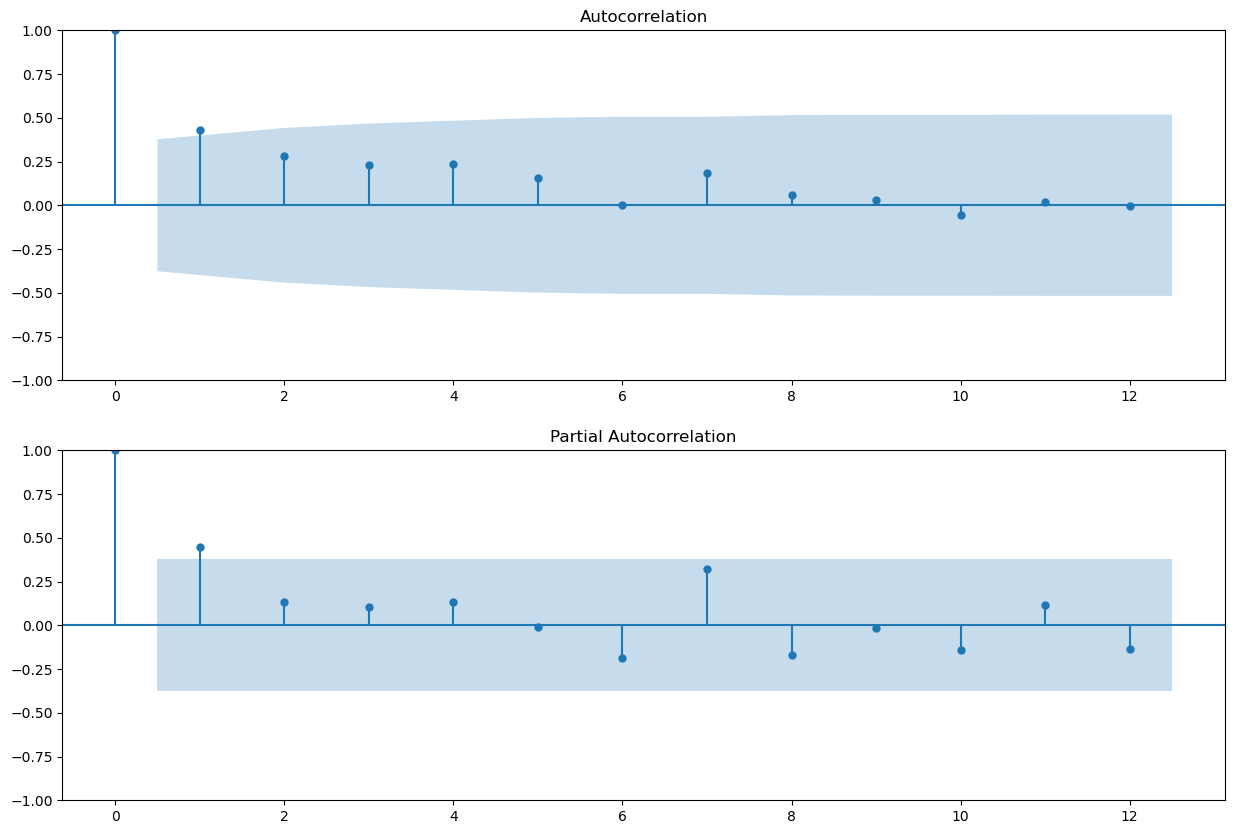

In [108]:
pyplot.figure(figsize=(15,10))
pyplot.subplot(211)
plot_acf(train1, ax=pyplot.gca(),lags=12)
pyplot.subplot(212)
plot_pacf(train1, ax=pyplot.gca(),lags=12)
pyplot.show()

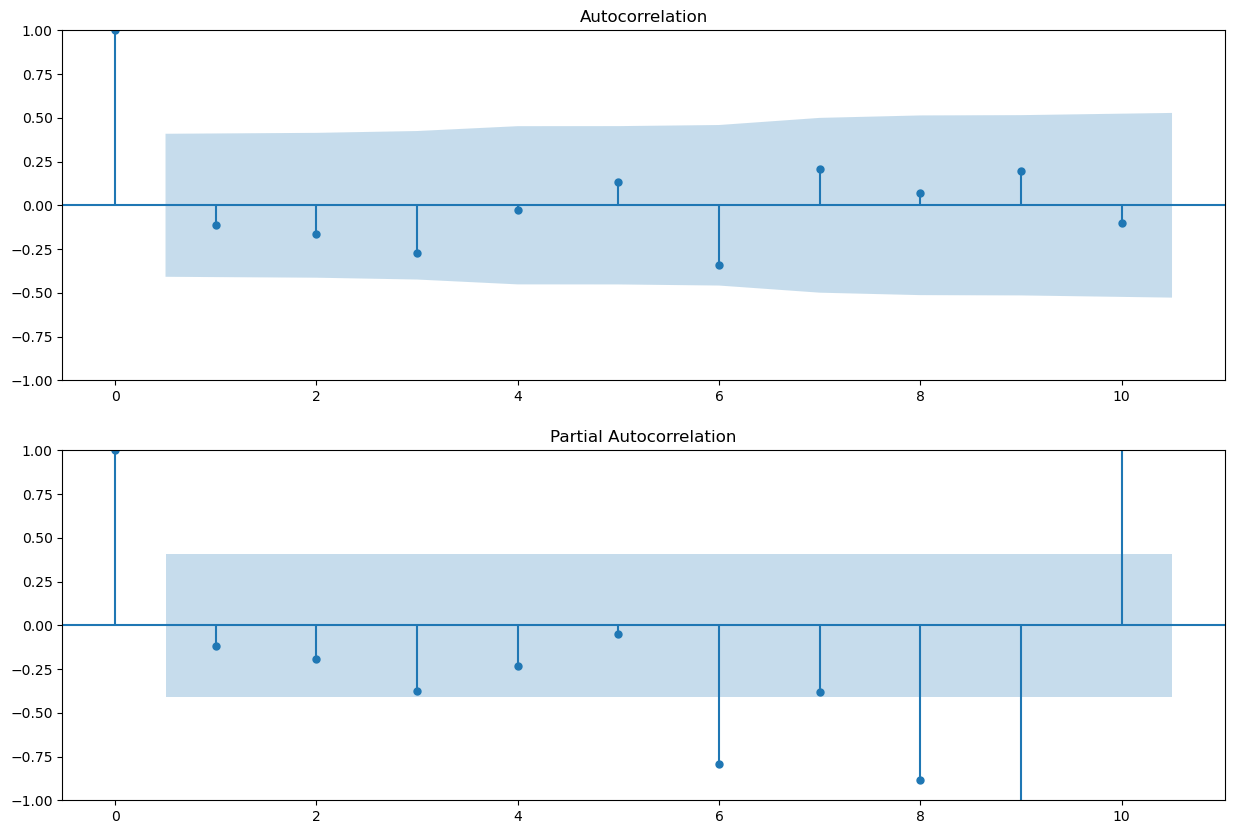

In [109]:
pyplot.figure(figsize=(15,10))
pyplot.subplot(211)
plot_acf(diff2, ax=pyplot.gca(),lags=10)
pyplot.subplot(212)
plot_pacf(diff2, ax=pyplot.gca(),lags=10)
pyplot.show()

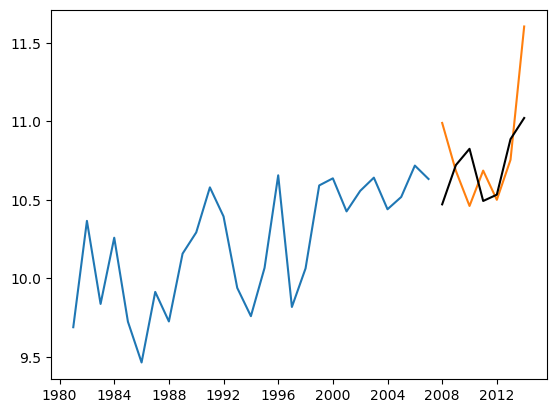

In [111]:
model = auto_arima(train1,seasonal=True, m=7)
model_auto = model.fit(train1)

forecast = model.predict(n_periods=len(test1))
forecast = pd.DataFrame(forecast,index = test.index,columns=['Prediction'])

#plot the predictions for validation set
plt.plot(train1, label='Train')
plt.plot(test1, label='Test')
plt.plot(forecast, label='Prediction', color='black')
plt.show()

In [139]:
print(model_auto.summary())

                                     SARIMAX Results                                     
Dep. Variable:                                 y   No. Observations:                   27
Model:             SARIMAX(2, 1, 2)x(0, 0, 2, 7)   Log Likelihood                  -3.604
Date:                           Sun, 24 Dec 2023   AIC                             23.208
Time:                                   16:01:28   BIC                             33.273
Sample:                               12-31-1980   HQIC                            26.107
                                    - 12-31-2006                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0444      0.034      1.297      0.195      -0.023       0.111
ar.L1         -0.4558      0.470     -0.971

In [140]:
#calculate the mean absolute error to measure error rate between the actual values and predicted values

print(mean_absolute_error(y_true=test1,y_pred=forecast))

0.2654425323758774


In [141]:
model1 = ARIMA(train1, order=(3,1,1),freq='A')
model_fit=model1.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:     AverageTemperature   No. Observations:                   27
Model:                 ARIMA(3, 1, 1)   Log Likelihood                  -7.776
Date:                Sun, 24 Dec 2023   AIC                             25.551
Time:                        16:01:57   BIC                             31.842
Sample:                    12-31-1980   HQIC                            27.363
                         - 12-31-2006                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1197      0.499      0.240      0.811      -0.859       1.098
ar.L2         -0.0995      0.299     -0.333      0.739      -0.685       0.486
ar.L3         -0.0377      0.244     -0.155      0.8

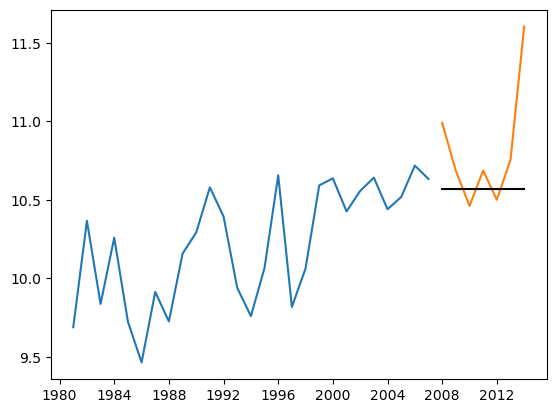

In [123]:
forecast1 = model_fit.forecast(steps=7)[0]

forecast1 = pd.DataFrame(forecast1,index = test.index,columns=['Prediction'])

#plot the predictions for validation set
plt.plot(train1, label='Train')
plt.plot(test1, label='Test')
plt.plot(forecast1, label='Prediction', color='black')
plt.show()

In [124]:
#calculate the mean absolute error to measure error rate between the actual values and predicted values

print(mean_absolute_error(y_true=test1,y_pred=forecast1))

0.29317819744771434


In [125]:
#To show the actual values Vs predicted values

print("Predicted Values")
print("*"*50)
print(forecast1)
print("-"*50)
print("Actual Values")
print("*"*50)
print(test1)

Predicted Values
**************************************************
            Prediction
dt                    
2007-12-31   10.568909
2008-12-31   10.568909
2009-12-31   10.568909
2010-12-31   10.568909
2011-12-31   10.568909
2012-12-31   10.568909
2013-12-31   10.568909
--------------------------------------------------
Actual Values
**************************************************
dt
2007-12-31    10.989940
2008-12-31    10.685179
2009-12-31    10.461537
2010-12-31    10.686661
2011-12-31    10.500732
2012-12-31    10.755588
2013-12-31    11.603875
Freq: A-DEC, Name: AverageTemperature, dtype: float64


In [127]:
model_sari = sm.tsa.SARIMAX(train1, order=(3,1,1), seasonal_order=(0,0,2,7))

In [128]:
model_fit_sari=model_sari.fit(disp=True)
print(model_fit_sari.summary())

                                       SARIMAX Results                                        
Dep. Variable:                     AverageTemperature   No. Observations:                   27
Model:             SARIMAX(3, 1, 1)x(0, 0, [1, 2], 7)   Log Likelihood                  -5.906
Date:                                Sun, 24 Dec 2023   AIC                             25.813
Time:                                        15:31:39   BIC                             34.619
Sample:                                    12-31-1980   HQIC                            28.349
                                         - 12-31-2006                                         
Covariance Type:                                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4023      0.462      0.871      0.384      -0.504       1.308
ar.

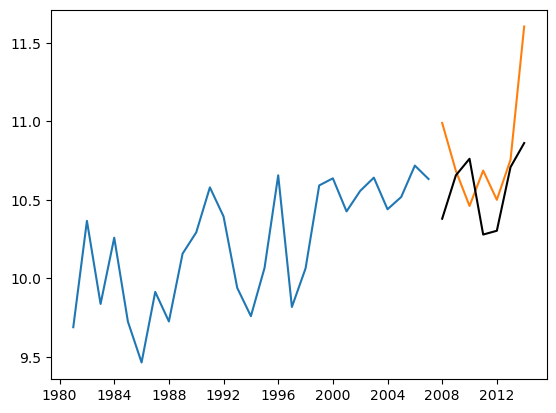

In [129]:
forecast_sari = model_fit_sari.forecast(steps=7)
#print(forecast)

#plot the predictions for validation set
plt.plot(train1, label='Train')
plt.plot(test1, label='Test')
plt.plot(forecast_sari, label='Prediction', color='black')
plt.show()

In [130]:
print(mean_absolute_error(y_true=test1,y_pred=forecast_sari))

0.3330786920281231


In [131]:
print("Predicted Values")
print("*"*50)
print(forecast_sari)
print("-"*50)
print("Actual Values")
print("*"*50)
print(test1)

Predicted Values
**************************************************
2007-12-31    10.380304
2008-12-31    10.656484
2009-12-31    10.761965
2010-12-31    10.279623
2011-12-31    10.303735
2012-12-31    10.708820
2013-12-31    10.861886
Freq: A-DEC, Name: predicted_mean, dtype: float64
--------------------------------------------------
Actual Values
**************************************************
dt
2007-12-31    10.989940
2008-12-31    10.685179
2009-12-31    10.461537
2010-12-31    10.686661
2011-12-31    10.500732
2012-12-31    10.755588
2013-12-31    11.603875
Freq: A-DEC, Name: AverageTemperature, dtype: float64


In [133]:
#This code to remove the logarithm of the values

converted_results = [(np.exp(x)) for x in [i for i in forecast_sari]]

In [136]:
converted_results

[32218.764759936064,
 42467.058180851745,
 47191.32924329488,
 29132.902445127016,
 29843.891835901675,
 44748.78689240036,
 52150.3225192613]

In [135]:
model_sari1 = sm.tsa.SARIMAX(train_data, order=(3,1,1), seasonal_order=(3,1,1,12))

In [142]:
model_fit_sari1=model_sari1.fit(disp=True)
print(model_fit_sari1.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                   27
Model:             SARIMAX(3, 1, 1)x(3, 1, 1, 12)   Log Likelihood                -208.574
Date:                            Sun, 24 Dec 2023   AIC                            435.147
Time:                                    16:10:43   BIC                            440.899
Sample:                                         0   HQIC                           434.615
                                             - 27                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3341      7.331      0.046      0.964     -14.035      14.703
ar.L2         -0.4621      0.677   

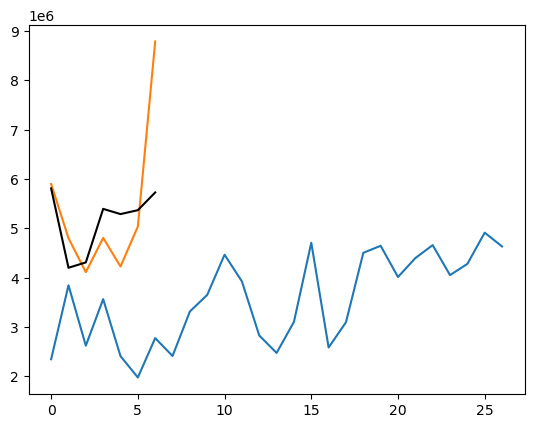

847808.7625246266


In [143]:
forecast_sari1 = model_fit_sari1.forecast(steps=7)
#print(forecast)

#plot the predictions for validation set
plt.plot(train_data, label='Train')
plt.plot(test_data, label='Test')
plt.plot(forecast_sari1, label='Prediction', color='black')
plt.show()
print(mean_absolute_error(y_true=test_data,y_pred=forecast_sari1))

In [144]:
forecast_sari1

array([5808930.04934179, 4198205.88277482, 4307226.10929022,
       5393333.71396978, 5287254.23509955, 5366752.87067717,
       5726370.10026486])

In [157]:
print(inv_boxcox(forecast_sari1, fitted_lambda))

[10.96690196 10.49199131 10.52872398 10.85648024 10.82712048 10.84917057
 10.94552189]


In [158]:
print(mean_absolute_error(y_true=test_data,y_pred=forecast_sari1))

847808.7625246266


In [168]:
def evaluate_arima_model(X, arima_order):
    # prepare training dataset
    train_size = int(len(X) * 0.80)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    # make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit(disp=0)
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    # calculate out of sample error
    error = mean_squared_error(test, predictions)
    return error

In [169]:
warnings.filterwarnings("ignore")

In [170]:
p_values = [0, 1, 2, 3]
d_values = range(0, 3) #this is the range for the values
q_values = range(0, 3) #this is the range for the values

In [171]:
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    mse = evaluate_arima_model(dataset, order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    print('ARIMA%s MSE=%.3f' % (order,mse))
                except:
                    continue
    print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))

In [172]:
evaluate_models(resample_df.values, p_values, d_values, q_values)

Best ARIMANone MSE=inf


In [179]:
def evaluate_arima_model(X, arima_order):
    # prepare training dataset
    train_size = int(len(X) * 0.80)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    # make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit()  # Remove the disp parameter here
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    # calculate out of sample error
    error = mean_squared_error(test, predictions)
    return error


In [180]:
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p, d, q)
                try:
                    mse = evaluate_arima_model(dataset, order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    print('ARIMA%s MSE=%.3f' % (order, mse))
                except Exception as e:
                    print(f'Error for order {order}: {e}')
                    continue
    print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))

# Assuming resample_df is a Pandas DataFrame with a single column
evaluate_models(resample_df.values, p_values, d_values, q_values)


ARIMA(0, 0, 0) MSE=0.424
ARIMA(0, 0, 1) MSE=0.296
ARIMA(0, 0, 2) MSE=0.285
ARIMA(0, 1, 0) MSE=0.163
ARIMA(0, 1, 1) MSE=0.170
ARIMA(0, 1, 2) MSE=0.167
ARIMA(0, 2, 0) MSE=0.222
ARIMA(0, 2, 1) MSE=0.157
ARIMA(0, 2, 2) MSE=0.135
ARIMA(1, 0, 0) MSE=0.237
ARIMA(1, 0, 1) MSE=0.199
ARIMA(1, 0, 2) MSE=0.193
ARIMA(1, 1, 0) MSE=0.173
ARIMA(1, 1, 1) MSE=0.168
ARIMA(1, 1, 2) MSE=0.165
ARIMA(1, 2, 0) MSE=0.198
ARIMA(1, 2, 1) MSE=0.166
ARIMA(1, 2, 2) MSE=0.148
ARIMA(2, 0, 0) MSE=0.227
ARIMA(2, 0, 1) MSE=0.194
ARIMA(2, 0, 2) MSE=0.190
ARIMA(2, 1, 0) MSE=0.166
ARIMA(2, 1, 1) MSE=0.166
ARIMA(2, 1, 2) MSE=0.165
ARIMA(2, 2, 0) MSE=0.152
ARIMA(2, 2, 1) MSE=0.157
ARIMA(2, 2, 2) MSE=0.155
ARIMA(3, 0, 0) MSE=0.210
ARIMA(3, 0, 1) MSE=0.192
ARIMA(3, 0, 2) MSE=0.183
ARIMA(3, 1, 0) MSE=0.180
ARIMA(3, 1, 1) MSE=0.167
ARIMA(3, 1, 2) MSE=0.186
ARIMA(3, 2, 0) MSE=0.201
ARIMA(3, 2, 1) MSE=0.169
ARIMA(3, 2, 2) MSE=0.158
Best ARIMA(0, 2, 2) MSE=0.135


In [181]:
train

dt
1980-12-31    2.271080
1981-12-31    2.338587
1982-12-31    2.286248
1983-12-31    2.328206
1984-12-31    2.274695
1985-12-31    2.247647
1986-12-31    2.294000
1987-12-31    2.274857
1988-12-31    2.318267
1989-12-31    2.331486
1990-12-31    2.358957
1991-12-31    2.341308
1992-12-31    2.296587
1993-12-31    2.278313
1994-12-31    2.309309
1995-12-31    2.366186
1996-12-31    2.284291
1997-12-31    2.308967
1998-12-31    2.360116
1999-12-31    2.364377
2000-12-31    2.344396
2001-12-31    2.356845
2002-12-31    2.364781
2003-12-31    2.345699
2004-12-31    2.353155
2005-12-31    2.371975
2006-12-31    2.363991
Freq: A-DEC, Name: AverageTemperature, dtype: float64

In [182]:
train_sizedf = int(len(df1) * 0.80)
traindf, testdf = df1[0:train_size], df1[train_size:]

In [183]:
traindf

,AverageTemperature
dt,
1980-12-31,9.689856
1981-12-31,10.366578
1982-12-31,9.837958
1983-12-31,10.259516
1984-12-31,9.724950
1985-12-31,9.465436
1986-12-31,9.914519
1987-12-31,9.726528
1988-12-31,10.158058


In [184]:
testdf

,AverageTemperature
dt,
2007-12-31,10.989940
2008-12-31,10.685179
2009-12-31,10.461537
2010-12-31,10.686661
2011-12-31,10.500732
2012-12-31,10.755588
2013-12-31,11.603875


In [195]:
traindf['ds'] = traindf.index
traindf['y'] = traindf['AverageTemperature']

In [196]:
traindf

,AverageTemperature,ds,y
dt,,,
1980-12-31,9.689856,1980-12-31,9.689856
1981-12-31,10.366578,1981-12-31,10.366578
1982-12-31,9.837958,1982-12-31,9.837958
1983-12-31,10.259516,1983-12-31,10.259516
1984-12-31,9.724950,1984-12-31,9.724950
1985-12-31,9.465436,1985-12-31,9.465436
1986-12-31,9.914519,1986-12-31,9.914519
1987-12-31,9.726528,1987-12-31,9.726528
1988-12-31,10.158058,1988-12-31,10.158058


In [202]:
# Apply Box-Cox Transform to value column and assign to new column y
traindf['y'], lam = stats.boxcox(traindf['AverageTemperature'])

In [203]:
acorr_ljungbox(traindf['y'], lags=[1], return_df=True)

,lb_stat,lb_pvalue
1,5.902979,0.015115


In [214]:
# Ensure 'AverageTemperature' is of numeric type
traindf['AverageTemperature'] = pd.to_numeric(traindf['AverageTemperature'], errors='coerce')

# Drop rows with missing values (if any)
traindf = traindf.dropna(subset=['AverageTemperature'])

# Run the ARIMA model
model = ARIMA(traindf['AverageTemperature'], order=(1, 1, 1))
model_fit = model.fit()

# Make predictions on the test set
predictions = model_fit.predict(start=len(traindf), end=len(traindf) + len(testdf) - 1, typ='levels')

# Create a DataFrame for predictions with columns 'Date' and 'Prediction_Value'
predictions_df = pd.DataFrame({'Date': testdf.index, 'Prediction_Value': predictions})

# Print predictions
print(predictions_df)

                 Date  Prediction_Value
2007-12-31 2007-12-31         10.574655
2008-12-31 2008-12-31         10.564885
2009-12-31 2009-12-31         10.563257
2010-12-31 2010-12-31         10.562986
2011-12-31 2011-12-31         10.562940
2012-12-31 2012-12-31         10.562933
2013-12-31 2013-12-31         10.562932


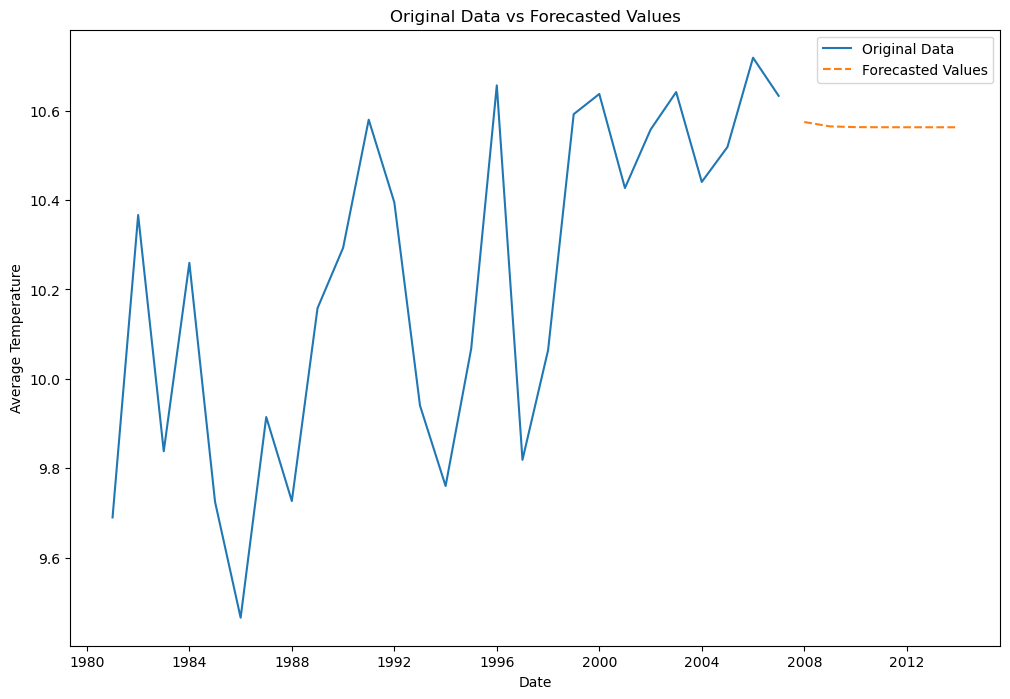

In [224]:
predictions_df['Date'] = pd.to_datetime(predictions_df['Date'])

# Plotting the original data and predictions on the same plot
plt.figure(figsize=(12, 8))
plt.plot(traindf.index, traindf['AverageTemperature'], label='Original Data')
plt.plot(predictions_df['Date'], predictions_df['Prediction_Value'], label='Forecasted Values', linestyle='--')
plt.title('Original Data vs Forecasted Values')
plt.xlabel('Date')
plt.ylabel('Average Temperature')
plt.legend()
plt.show()